In [1]:
cd ..

/home/yann/IVISpaces


In [28]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL,  Entropy, evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [29]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5



#optimizer
learning_rate=0.005

#scheduler
patience=25
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [30]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

torch.manual_seed(42)

# Setup #

In [31]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='concrete' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

#sigma_noise=setup.sigma_noise
print(setup.sigma_noise)

sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
print(size_data)
#batch_size
batch_size=50#int(np.min([size_data/6,500]))
if dataset=='powerplant':
    batch_size=50

n_samples_FU=200 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0#batch_size#30 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

4.5
927


# Predictive model #

In [32]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

param_count

501

# Priors #

Text(0.5, 1.0, 'prior on sigma_noise')

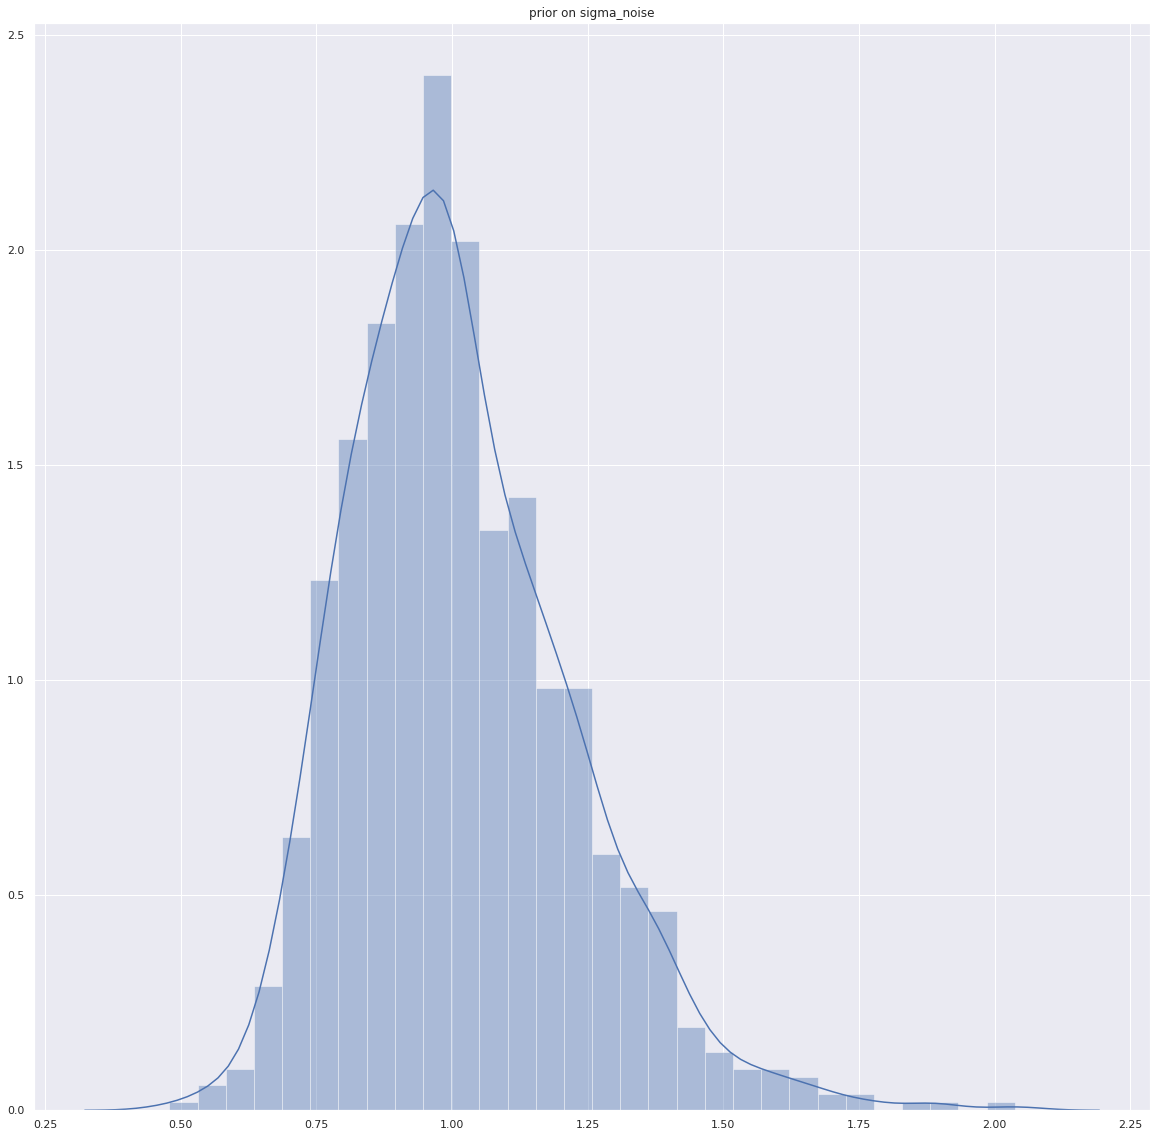

In [63]:
#prior on weights
def prior_weights(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)

#prior on log (sigma_noise) N(0,0.5)
def prior_noise(n):
    return 0.2*torch.randn(size=(n,1), device=device)

def prior(n):
    return torch.cat([prior_weights(n),prior_noise(n)],dim=1)

import seaborn as sns
#sns.distplot(sigma_noise)
sns.distplot(prior_noise(1000).cpu().exp())
plt.title('prior on sigma_noise')

# ELBO

## Average Log Likelihood

In [64]:
from Tools import log_norm
#average log likelihood loss 
###!!!!!!! TODO

""" 
    log_norm
    Evaluation of 1D normal distribution on tensors

    Parameters:
        x (Tensor): Data tensor of size S x N x 1 
        mu (Tensor): Mean tensor of size B x S x 1
        std (Float): Tensor of size B (standard deviation)

    Returns:
        logproba (Tensor): size B x S x N x 1 with logproba[b,s,n]=[log p(x(s,n)|mu(b,s),std[b])]
    """

def average_loglikelihood(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """
    theta_s=GeN(n_samples_LL)
    theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)
    y_pred=model(x_data,theta)
    sigma=log_sigma.exp().unsqueeze(1)
    log_proba = log_norm( y_data.unsqueeze(1), y_pred, sigma).view(y_pred.shape[0],y_pred.shape[1])
    return log_proba.sum(1).mean(0)



## Kullback-Leibler divergence in Predictor space

In [65]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
    epsilon=0.1
    M = x_train.max(0, keepdim=True)[0]+epsilon
    m = x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model


def kl(x_data, GeN, beta):

    theta_s=GeN(n_samples_KL) #variationnel
    theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)

    theta_prior_weights=prior_weights(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior_weights,x_data)
    theta_var=torch.cat([theta_proj,log_sigma],dim=1)
    theta_prior=torch.cat([theta_prior_proj,prior_noise(n_samples_KL)],dim=1)
    
    K=KL(theta_var, theta_prior,k=kNNE,device=device, beta=beta)
    return K

def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [66]:
#ELBO
 #KL regularizer
    
def ELBO(x_data, y_data, GeN):
    alpha=(len(x_data)/size_data)
    beta=1. #TO DO
    Average_LL=average_loglikelihood(x_data, y_data, GeN)
    the_KL=kl(x_data, GeN, beta)
    the_ELBO= - Average_LL+ alpha* the_KL#(len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, Average_LL


# Generative model #

In [67]:
#generative model
GeN = BigGenerator(lat_dim,param_count+1,device).to(device)


# A priori Base Line #

In [68]:

theta_s=GeN(1000).detach()
theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)
y_pred=model(x_test,theta)
sigma_noise=log_sigma.exp().detach().unsqueeze(1).cpu()

evaluate_metrics(y_pred, sigma_noise, y_test,  std_y_train, device='cpu', std=True)

{'RMSE': (15.144169807434082, 16.694374084472656),
 'LPP': (-1.323734164237976, 0.6251627206802368),
 'WAIC': -1.4856883436441422,
 'PICP': 0.9223300814628601,
 'MPIW': 59.56121826171875}

In [69]:
from Metrics import LPP

mu=y_train.mean()
sigma=y_train.std()
y_pred=mu*torch.ones(1000,y_test.shape[0],1).to(device)

sigma_noise_train=sigma.view(1,1,1).cpu()
evaluate_metrics(y_pred, sigma_noise_train, y_test,  std_y_train, device='cpu', std=True)


{'RMSE': (15.22751235961914, 17.343547821044922),
 'LPP': (-1.3272068500518799, 0.5289191603660583),
 'WAIC': -1.3272068500518799,
 'PICP': 0.9611650705337524,
 'MPIW': 66.08750915527344}

# Optimizer

In [70]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [71]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [72]:
KLs=[]
ELBOs=[]
LRs=[]
LLs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[]          
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:

        theta_s=GeN(1000).detach()
        theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)
        sigma_noise=log_sigma.exp().unsqueeze(1).detach().cpu()
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, sigma_noise, y_test,  std_y_train, device='cpu', std=False)
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])

        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])

        
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



  3%|▎         | 131/5000 [00:40<27:29,  2.95it/s, ELBO=10.9, KL=127, LogLike=-4.12, lr=0.005]

Epoch   131: reducing learning rate of group 0 to 2.5000e-03.


  7%|▋         | 330/5000 [01:40<25:56,  3.00it/s, ELBO=-3.78, KL=96.7, LogLike=8.93, lr=0.0025] 

Epoch   330: reducing learning rate of group 0 to 1.2500e-03.


  7%|▋         | 374/5000 [01:55<26:19,  2.93it/s, ELBO=-7.05, KL=90.1, LogLike=11.8, lr=0.00125]

Epoch   374: reducing learning rate of group 0 to 6.2500e-04.


  8%|▊         | 424/5000 [02:09<18:42,  4.08it/s, ELBO=-9.37, KL=85.1, LogLike=13.9, lr=0.000625]

Epoch   424: reducing learning rate of group 0 to 3.1250e-04.


  9%|▉         | 458/5000 [02:20<26:07,  2.90it/s, ELBO=-10.2, KL=84.4, LogLike=14.7, lr=0.000313]

Epoch   458: reducing learning rate of group 0 to 1.5625e-04.


 10%|▉         | 485/5000 [02:29<26:07,  2.88it/s, ELBO=-10.5, KL=84.2, LogLike=15, lr=0.000156]  

Epoch   485: reducing learning rate of group 0 to 1.0000e-04.


 10%|▉         | 485/5000 [02:30<23:18,  3.23it/s, ELBO=-11, KL=85.2, LogLike=15.5, lr=0.0001]  


# Results on test #

In [77]:
#compute metrics on test
log_device='cpu'
theta_s=GeN(10000).detach()
theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)
sigma_noise=log_sigma.exp().unsqueeze(1).detach().cpu()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, sigma_noise, y_test, std_y_train, device='cpu')
metrics.update({'time [s]':execution_time})
mu=y_train.mean()
sigma=y_train.std()
y_pred=mu*torch.ones_like(y_test)
sigma_noise_train=sigma.view(1,1,1)
ref_LPP=LPP(y_pred.unsqueeze(0), y_test, sigma_noise_train, 'cpu')[0]
metrics.update({'SLPP':metrics['LPP'][0]-ref_LPP})
print(std_y_train)
print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

  

tensor(16.8536, device='cuda:0')
concrete
RMSE: (4.573086738586426, 7.718694686889648)
LPP: (-0.33042216300964355, 3.2522189617156982)
WAIC: -0.5951427519321442
PICP: 0.8737863898277283
MPIW: 11.774371147155762
time [s]: 150.20768036996014
SLPP: 0.9967848062515259


NameError: name 'tensor' is not defined

Text(0.5, 1.0, 'posterior on sigma_noise')

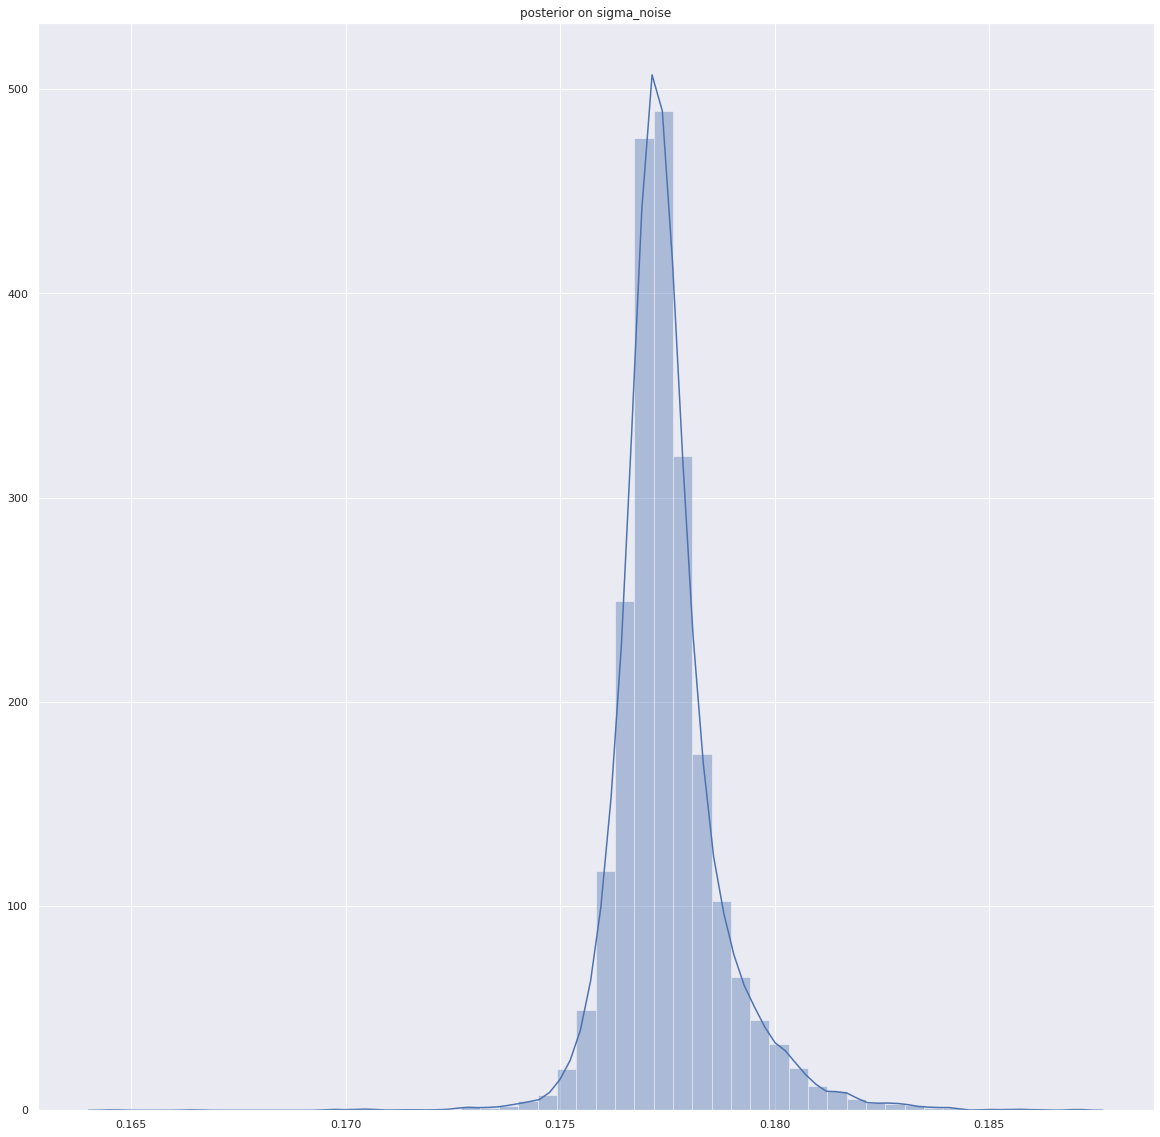

In [80]:
sns.distplot(sigma_noise)
plt.title('posterior on sigma_noise')  

In [81]:
def predict(GeN, n, x):
    theta_s=GeN(n).detach()
    theta, log_sigma=theta_s.split([theta_s.shape[1]-1,1],dim=1)
    pred=model(x,theta)
    sigma_noise=log_sigma.exp().unsqueeze(1).detach() #homeoscedastic
    pred_noise=pred+sigma_noise*torch.randn_like(pred)
    return pred, pred_noise
p,p_=predict(GeN, 100, x_test)
p.shape, p_.shape

(torch.Size([100, 103, 1]), torch.Size([100, 103, 1]))

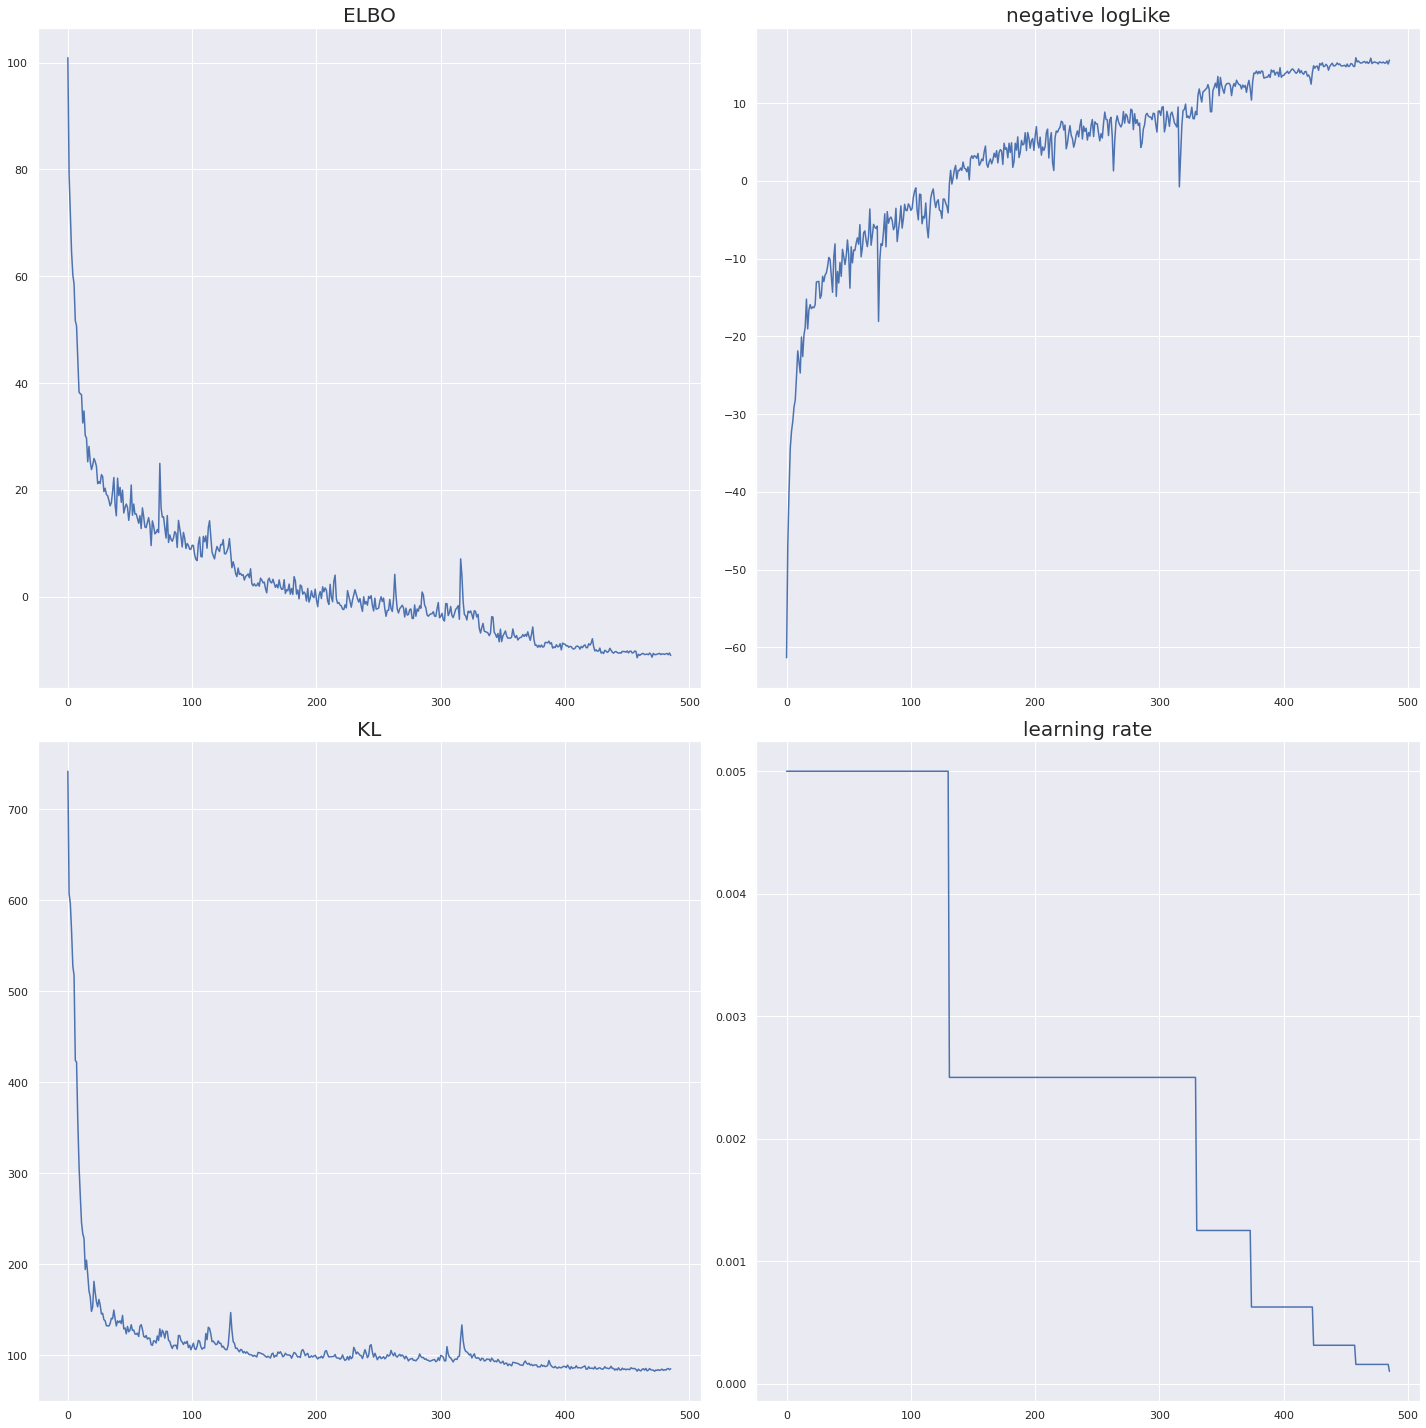

In [82]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LL_=torch.as_tensor(training['LL'])
LR_=torch.as_tensor(training['LR'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)

fig.tight_layout()

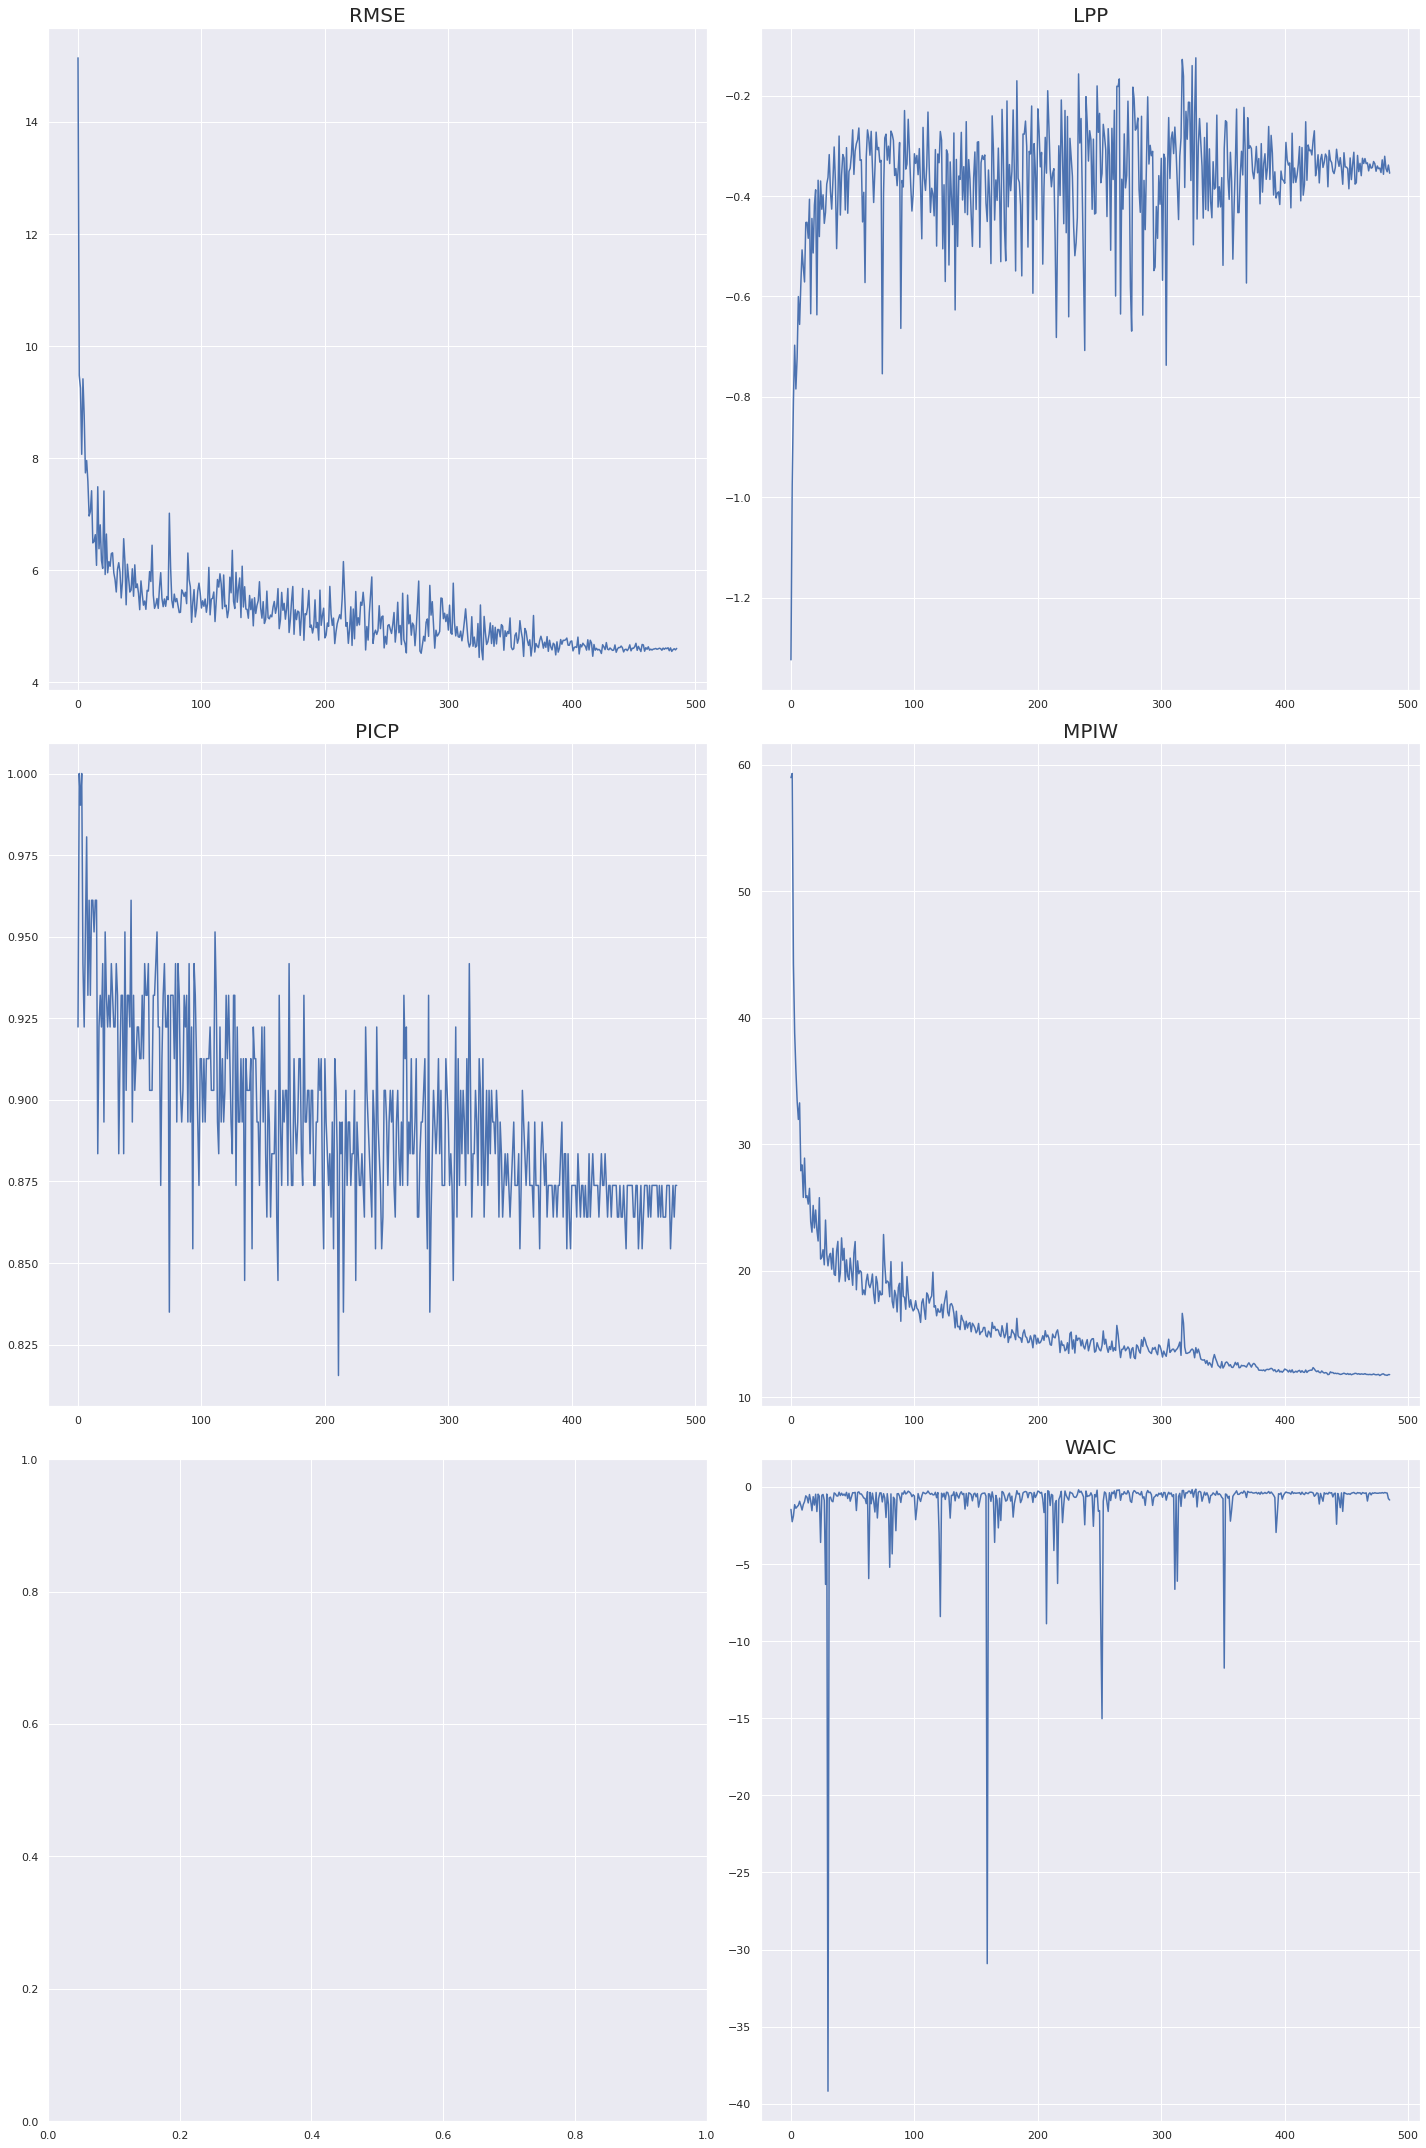

In [83]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(3,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
m='WAIC'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m, fontsize=20)

fig.tight_layout()

# posterior predictive diagnostic #

Text(0.5, 0.98, 'On train')

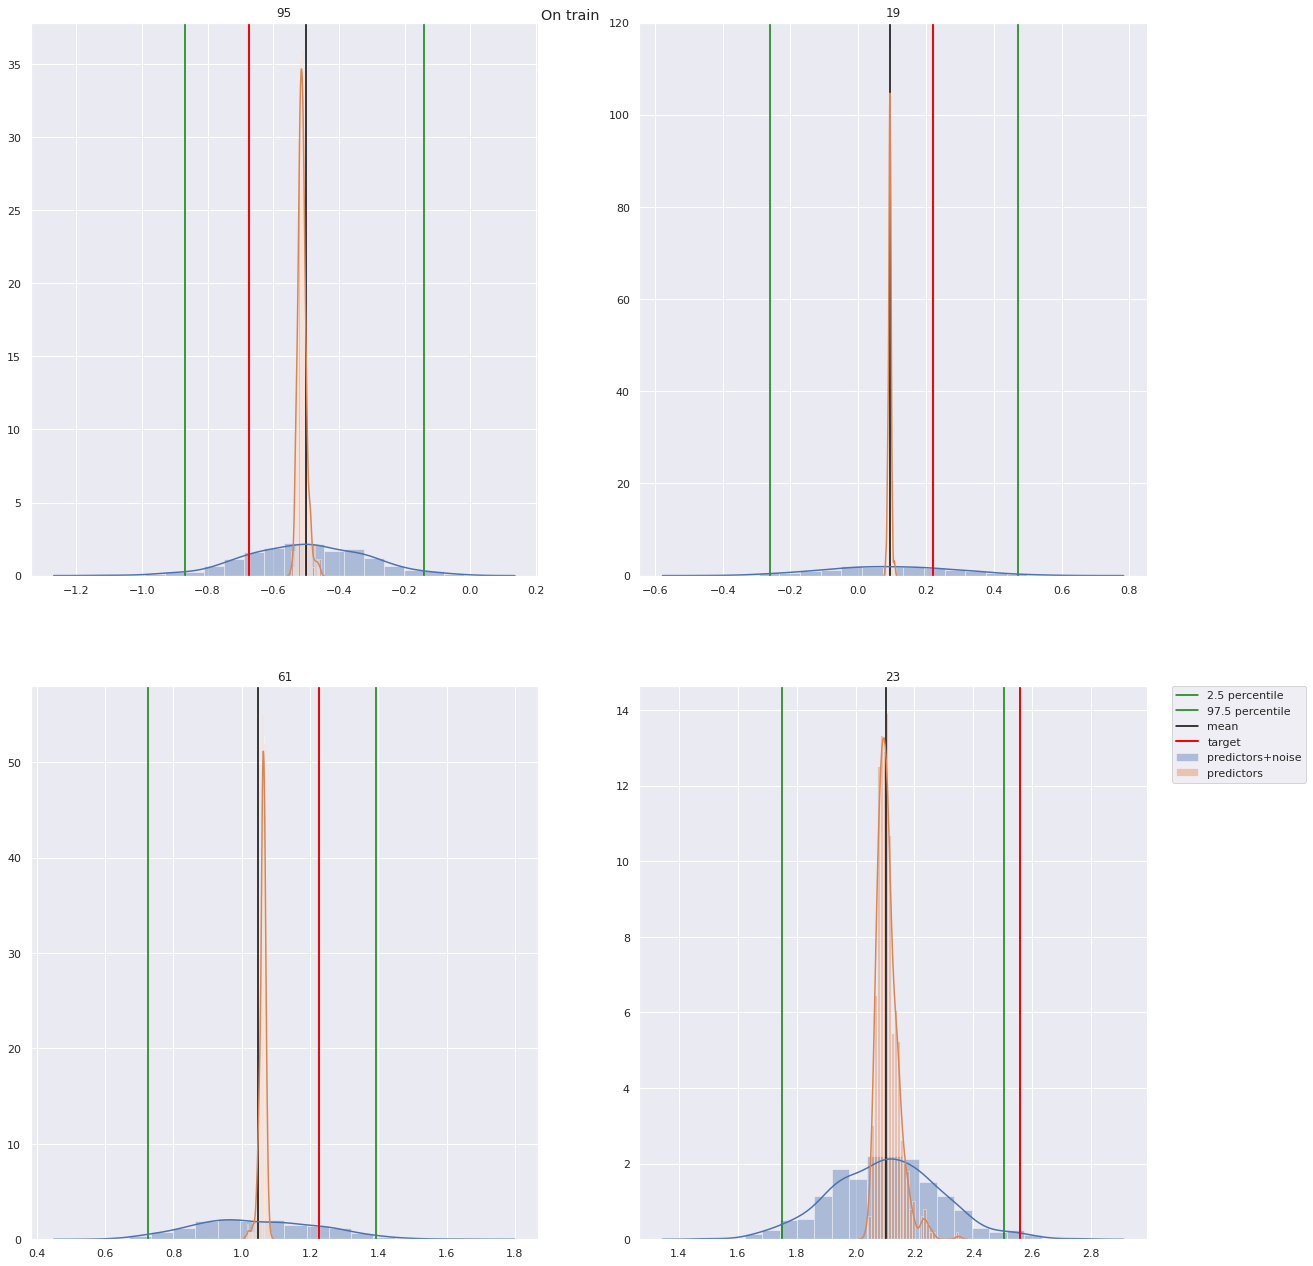

In [84]:
import seaborn as sns
from pylab import *
from Tools import log_norm

n_predictors=500
pred, pred_ =predict(GeN,n_predictors,x_train)


M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)



sns_plot=sns.set(rc={"figure.figsize": (20, 20)}, )
N=2
M=2

for _ in range(0,N*M):
    i=torch.randint(0,y_test.shape[0],()).item()
    subplot(N,M,_+1)

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', label='mean')
#    ax=sns.distplot(pred_prior[:,i], label='prior')
#    ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    ax =sns.distplot(pred_[:,i].cpu(),label='predictors+noise')
    ax =sns.distplot(pred[:,i].cpu(),label='predictors')

    line1=plt.axvline(y_train[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='On train')



Text(0.5, 0.98, 'RMSE on test=4.57, LPP on test=-0.33)')

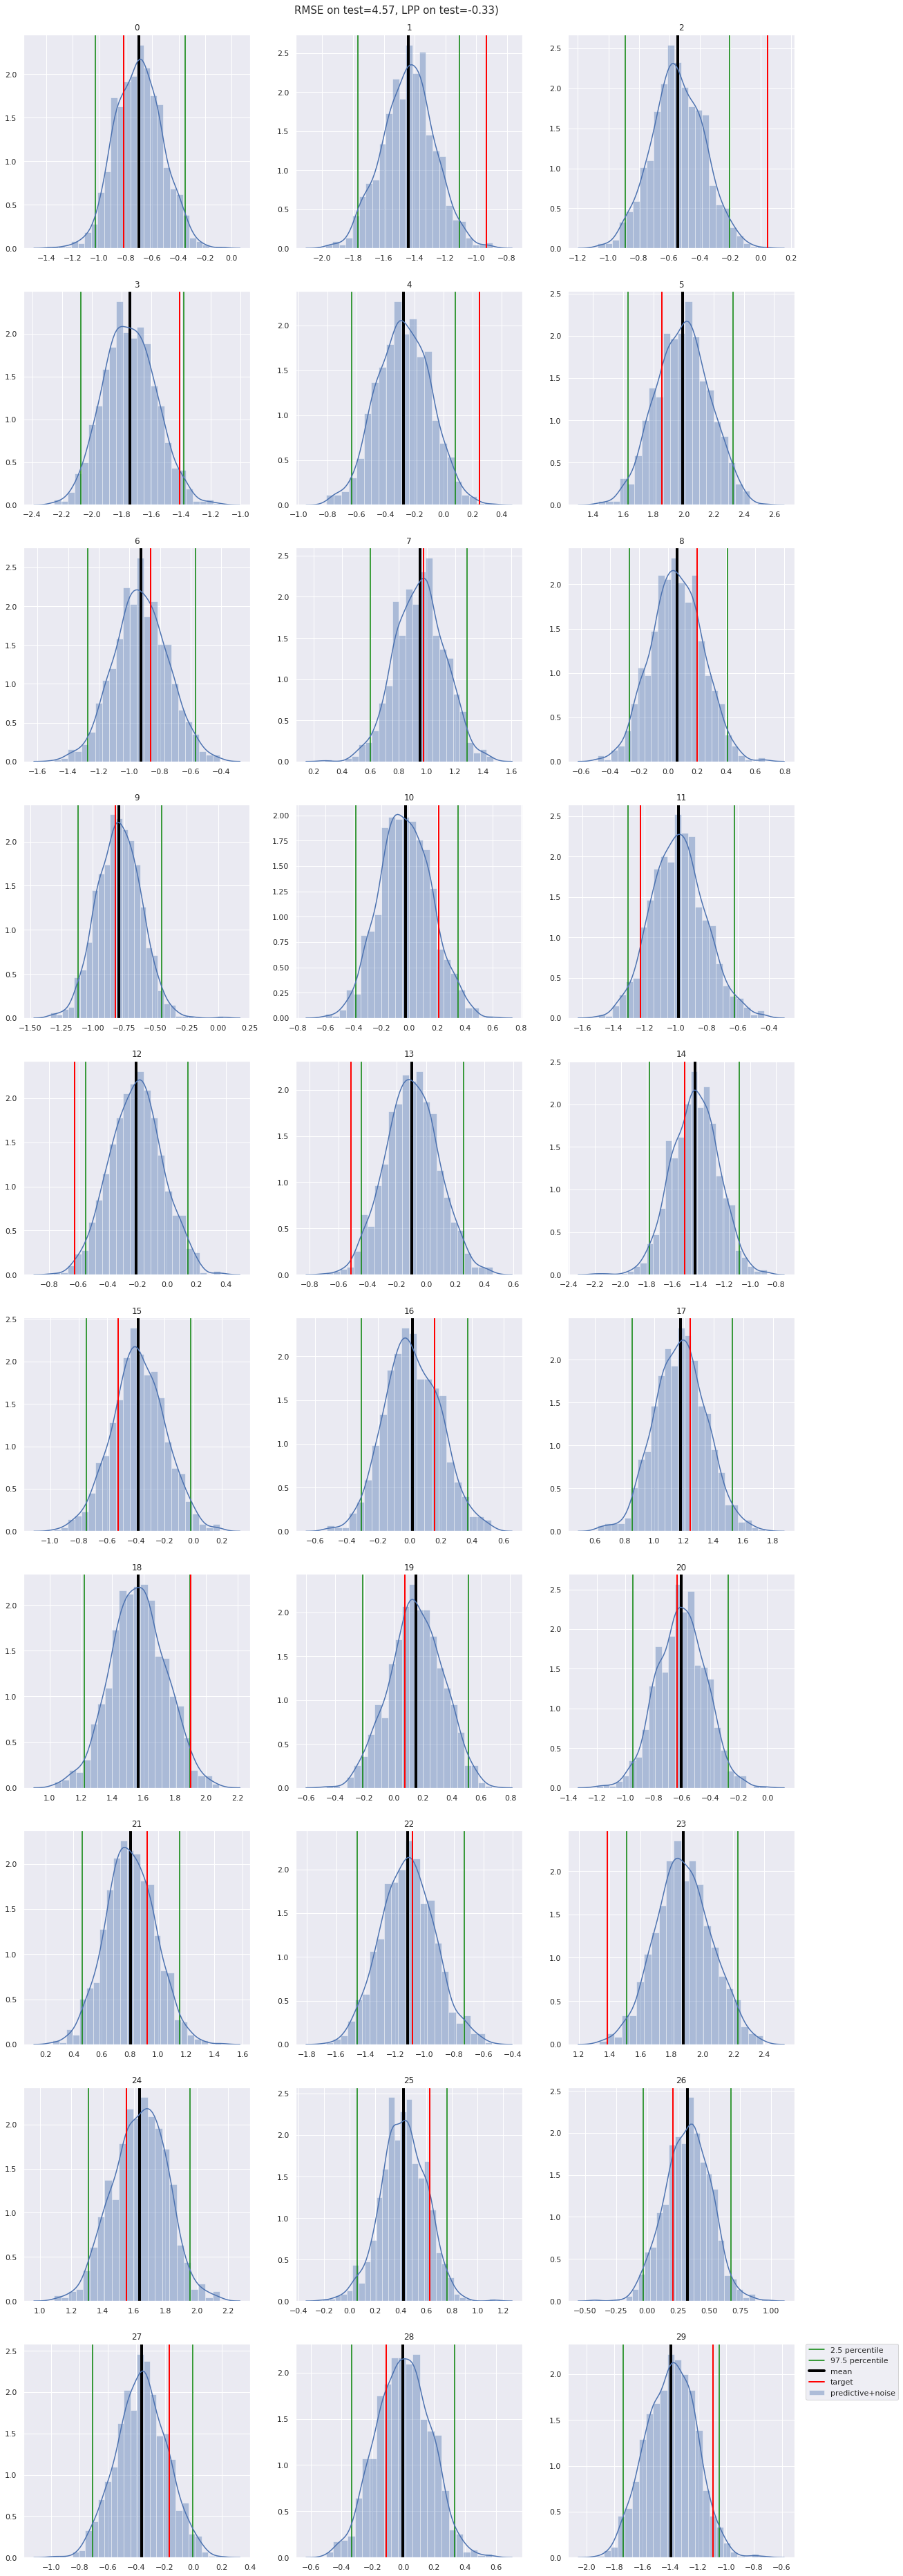

In [85]:
import seaborn as sns
from pylab import *

pred, pred_ =predict(GeN,1000,x_test)

M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)


sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
N=10
M=3

for i in range(N*M):
    
    subplot(N,M,i+1)
#    plt.plot(lin_y.view(-1,300)[i].squeeze().cpu(),LPP[i].exp().cpu(), label='posterior predictive')

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', lw=4.,label='mean')
 #   ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    line5 =ax=sns.distplot(pred_[:,i].cpu(),label='predictive+noise')
  #  line5 =ax=sns.distplot(pred[:,i].cpu(),label='predictive')

    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='RMSE on test={:.2f}, LPP on test={:.2f})'.format(metrics['RMSE'][0],metrics['LPP'][0]),fontsize=15)


Text(0.5, 0.98, 'out of distribution')

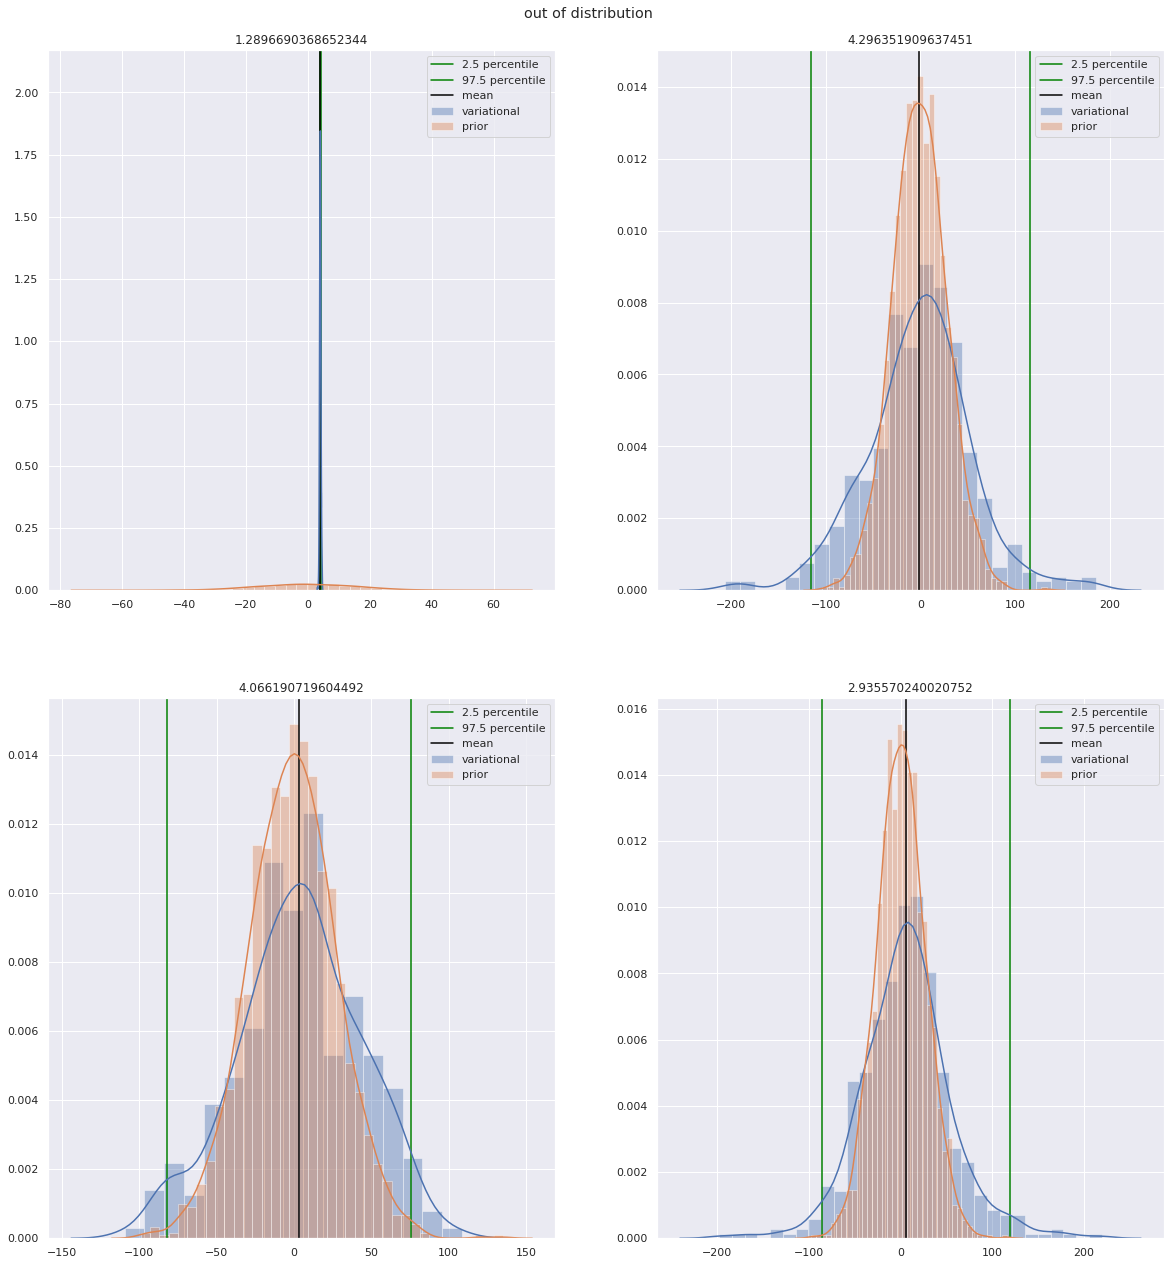

In [86]:
import seaborn as sns
from pylab import *
torch.manual_seed(seed=43) 


theta=GeN(2000).detach()
epsilon=0.1
n_ood=9
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
pred, pred_=predict(GeN,n_predictors,X_ood)



theta_prior=prior_weights(2000)
pred_prior=model(X_ood,theta_prior).cpu()
pred_HMC=model(X_ood,HMC).cpu()


M = pred.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)


y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)



sns.set(rc={"figure.figsize": (20, 20)})
N=2

for i in range(N**2):
    subplot(N,N,i+1)

    plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred.mean(0)[i].cpu(), color='black', label='mean')
    
    plt.title(str(torch.cdist(X_ood[i].unsqueeze(0), x_train).min().item()))
    ax=sns.distplot(pred_[:,i].cpu(), label='variational')
    ax=sns.distplot(pred_prior[:,i], label='prior')
 #   ax=sns.distplot(pred_HMC[:,i], label='HMC')

    plt.legend()
plt.subplots_adjust(top=.95)
plt.suptitle(t='out of distribution')

# Uncertainty vs Error #

500
500


Text(0.5, 0, 'Uncertainty (Diff Entropy)')

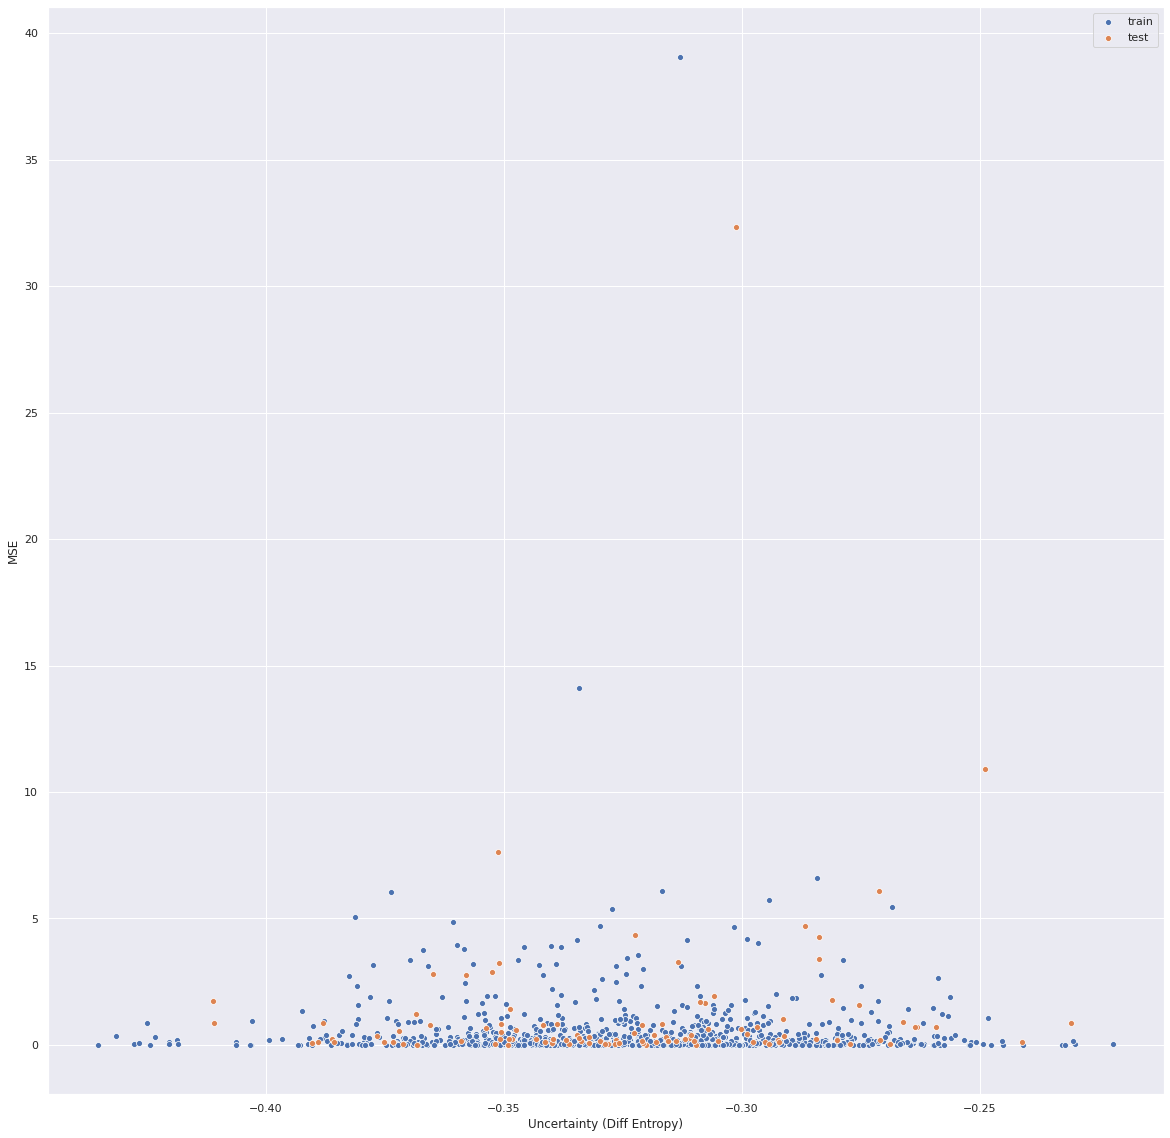

In [87]:
X=[x_train,x_test]
y=[y_train,y_test]
label=['train', 'test']
def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)



for i in range(len(X)):
    _,pred=predict(GeN,500,X[i])

    M = pred.shape[0]
    print(M)
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))


    H=(Entropy(pred.transpose(0,1),k=20))
    STD=(pred.std(0).squeeze())
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    ax=sns.scatterplot(H.cpu(),MSE.cpu(), label=label[i])
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')

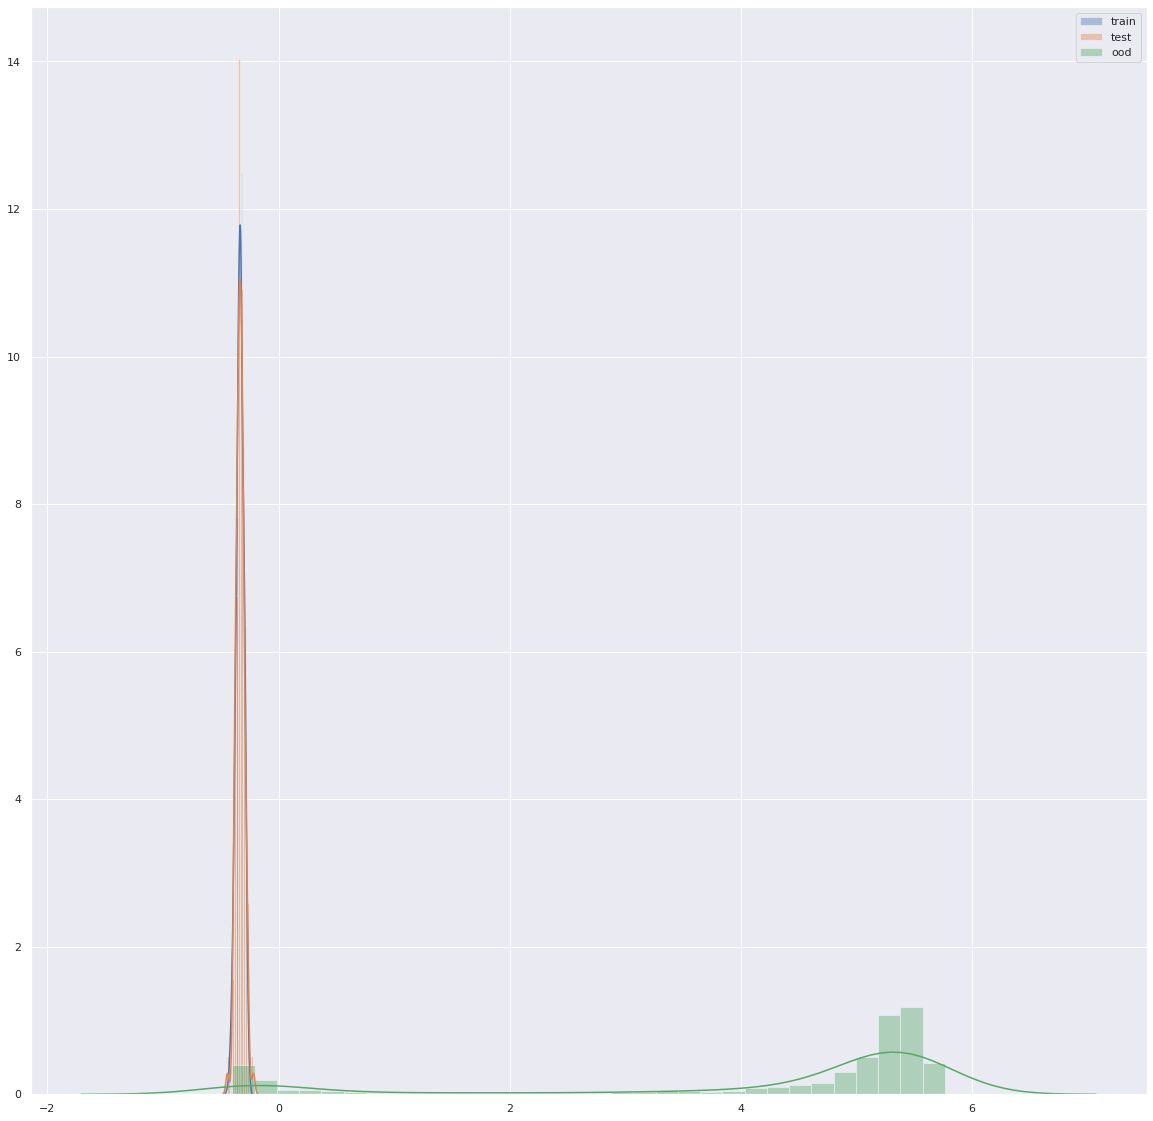

In [89]:
epsilon=0.1
n_ood=2000
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
X=[x_train,x_test,X_ood]
label=['train','test','ood']
for i in range(len(X)):
    _, pred=predict(GeN,500,X[i])
    H=Entropy(pred.transpose(0,1),k=30)
    ax=sns.distplot(H, label=label[i])
plt.legend()
